# DDPG BipedalWalker

In [1]:
import sys,os
import random
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import gym
import tensorflow.compat.v1 as tf
import numpy as np
import time
import cv2

# Deep Deterministic Policy Gradient
## experience replay
## fixed target network

In [2]:
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()

        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())
        
        self.writer = tf.summary.FileWriter("log", graph=self.sess.graph)

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 64, activation=tf.nn.relu, name='l1', trainable=trainable)
            l2 = tf.layers.dense(l1, 64, activation=tf.nn.relu, name='l2', trainable=trainable)
            l3 = tf.layers.dense(l2, 64, activation=tf.nn.relu, name='l3', trainable=trainable)
            a = tf.layers.dense(l3, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 64
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            l1 = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            l2 = tf.layers.dense(l1, 64, activation=tf.nn.relu, name='l2', trainable=trainable)
            l3 = tf.layers.dense(l2, 64, activation=tf.nn.relu, name='l3', trainable=trainable)
            return tf.layers.dense(l3, 1, trainable=trainable)  # Q(s,a)

# Train OpenAI Gym BipedalWalker with DDPG

In [ ]:
MAX_EPISODES = 500
MAX_EP_STEPS = 1000

env = gym.make('BipedalWalker-v2')
env = env.unwrapped
env.seed(1)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
a_bound = env.action_space.high

print("action:",env.action_space)
print("observation:",env.observation_space)

ddpg = DDPG(a_dim, s_dim, a_bound)

var = 3  # control exploration
t1 = time.time()
for i in range(MAX_EPISODES):
    s = env.reset()
    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        env.render()

        # Add exploration noise
        a = ddpg.choose_action(s)
        
        # add randomness to action selection for exploration
        a = np.clip(np.random.normal(a, var), -1, 1)
        
        s_, r, done, info = env.step(a)

        ddpg.store_transition(s, a, r, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            var *= .9999    # decay the action randomness
            ddpg.learn()

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, )
            break
            
print('Running time: ', time.time() - t1)

action: Box(4,)
observation: Box(24,)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Episode: 0  Reward: -108 Explore: 3.00
Episode: 1  Reward: -106 Explore: 3.00
Episode: 2  Reward: -95 Explore: 3.00
Episode: 3  Reward: -93 Explore: 3.00
Episode: 4  Reward: -105 Explore: 3.00
Episode: 5  Reward: -105 Explore: 3.00
Episode: 6  Reward: -100 Explore: 3.00
Episode: 7  Reward: -121 Explore: 3.00
Episode: 8  Reward: -107 Explore: 3.00
Episode: 9  Reward: -107 Explore: 3.00
Episode: 10  Reward: -93 Explore: 3.00
Episode: 11  Reward: -99 Explore: 3.00
Episode: 12  Reward: -113 Explore: 3.00
Episode: 13  Reward: -106 Explore: 3.00
Episode: 14  Reward: -105 Explore: 3.00
Episode: 15  Reward: -89 Explore: 3.00
Episode: 16  Reward: -118 Explore: 3.00
Episode: 17  Reward: -99 E

Episode: 180  Reward: -121 Explore: 0.30
Episode: 181  Reward: -117 Explore: 0.30
Episode: 182  Reward: -117 Explore: 0.30
Episode: 183  Reward: -124 Explore: 0.29
Episode: 184  Reward: -122 Explore: 0.29
Episode: 185  Reward: -114 Explore: 0.29
Episode: 186  Reward: -114 Explore: 0.29
Episode: 187  Reward: -115 Explore: 0.29
Episode: 188  Reward: -124 Explore: 0.28
Episode: 189  Reward: -126 Explore: 0.28
Episode: 190  Reward: -103 Explore: 0.28
Episode: 191  Reward: -101 Explore: 0.28
Episode: 192  Reward: -106 Explore: 0.27
Episode: 193  Reward: -99 Explore: 0.27
Episode: 194  Reward: -101 Explore: 0.27
Episode: 195  Reward: -102 Explore: 0.27
Episode: 196  Reward: -100 Explore: 0.27
Episode: 197  Reward: -104 Explore: 0.27
Episode: 198  Reward: -100 Explore: 0.26
Episode: 199  Reward: -119 Explore: 0.26
Episode: 200  Reward: -89 Explore: 0.24
Episode: 201  Reward: -124 Explore: 0.24
Episode: 202  Reward: -125 Explore: 0.23
Episode: 203  Reward: -108 Explore: 0.23
Episode: 204  Rewa

Episode: 380  Reward: -112 Explore: 0.02
Episode: 381  Reward: -111 Explore: 0.02
Episode: 382  Reward: -111 Explore: 0.02
Episode: 383  Reward: -111 Explore: 0.02
Episode: 384  Reward: -113 Explore: 0.02
Episode: 385  Reward: -110 Explore: 0.02
Episode: 386  Reward: -126 Explore: 0.02
Episode: 387  Reward: -108 Explore: 0.02
Episode: 388  Reward: -110 Explore: 0.01
Episode: 389  Reward: -110 Explore: 0.01
Episode: 390  Reward: -110 Explore: 0.01
Episode: 391  Reward: -113 Explore: 0.01
Episode: 392  Reward: -113 Explore: 0.01
Episode: 393  Reward: -107 Explore: 0.01
Episode: 394  Reward: -111 Explore: 0.01
Episode: 395  Reward: -111 Explore: 0.01
Episode: 396  Reward: -110 Explore: 0.01
Episode: 397  Reward: -109 Explore: 0.01
Episode: 398  Reward: -111 Explore: 0.01
Episode: 399  Reward: -111 Explore: 0.00
Episode: 400  Reward: -98 Explore: 0.00
Episode: 401  Reward: -123 Explore: 0.00
Episode: 402  Reward: -123 Explore: 0.00
Episode: 403  Reward: -123 Explore: 0.00
Episode: 404  Rew

# check out your VNC
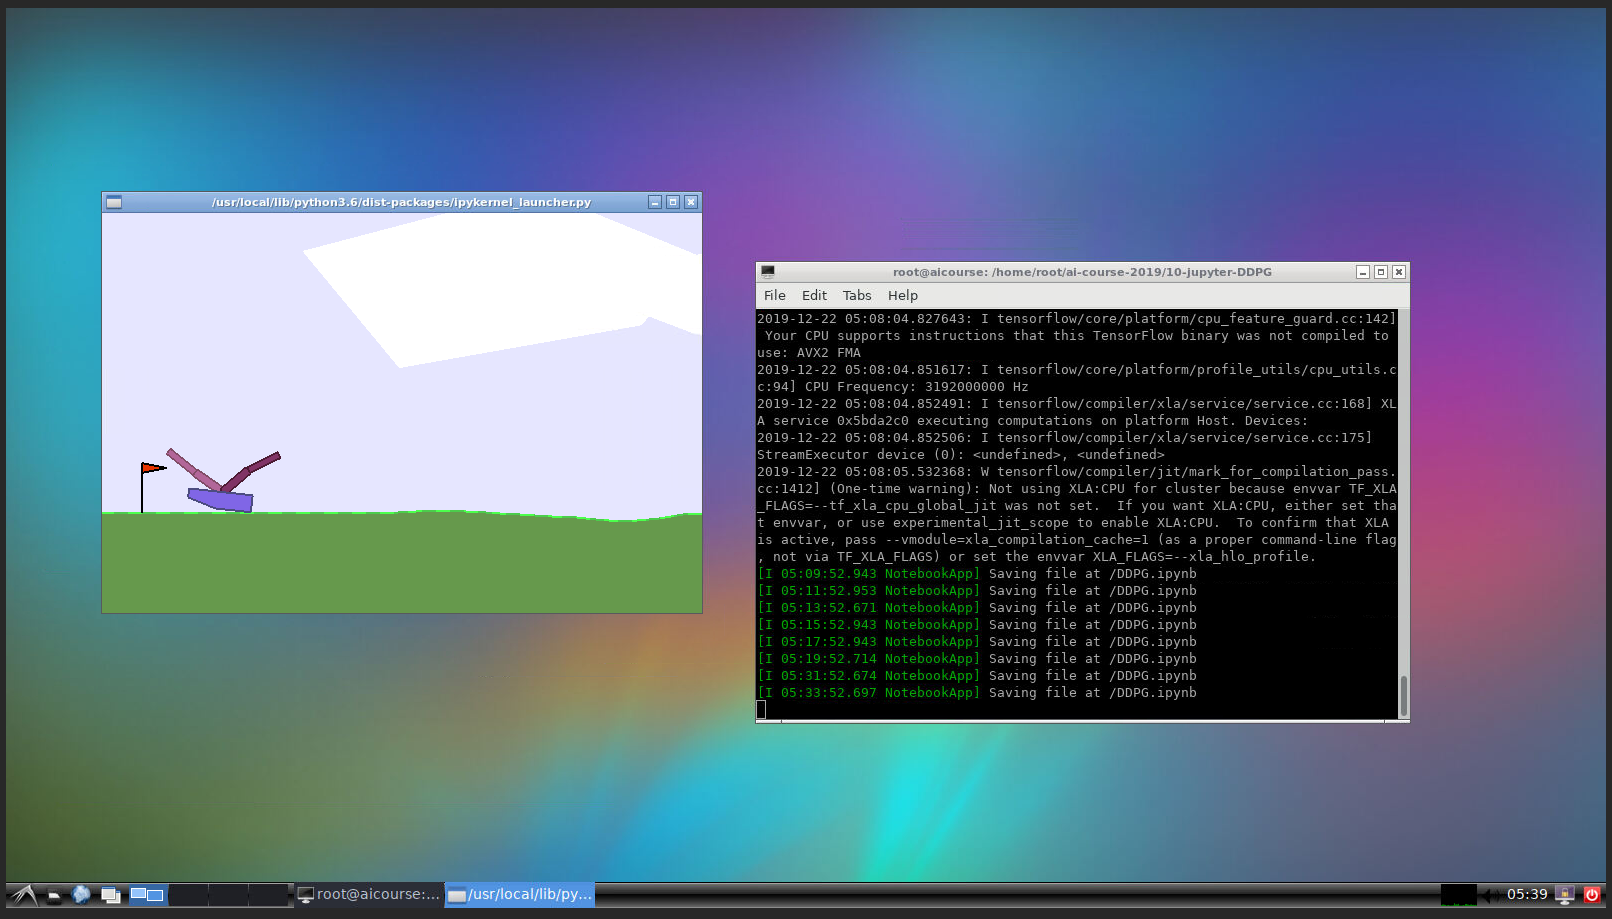